**Environment Setup and Data Cleaning**

In [22]:
# Install & import all necessary libraries

# Core data handling
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Machine-learning utilities
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    precision_recall_curve,
    ConfusionMatrixDisplay,
    RocCurveDisplay
)
import joblib

# Global plotting style
sns.set(style="whitegrid")

In [23]:
# Load the dataset
raw = fetch_openml(data_id=1461, as_frame=True).frame

# Renaming columns
rename_map = {
    'V1':'age',        'V2':'job',        'V3':'marital',   'V4':'education',
    'V5':'default',    'V6':'balance',    'V7':'housing',   'V8':'loan',
    'V9':'contact',    'V10':'day',       'V11':'month',    'V12':'duration',
    'V13':'campaign',  'V14':'pdays',     'V15':'previous', 'V16':'poutcome',
    'Class':'y'
}

data = raw.rename(columns=rename_map)

# Check
display(data.head())

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,1
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,1
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,1
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,1
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,1


In [24]:
# Drop rows with unknown job or education
mask_known = (data['job'] != 'unknown') & (data['education'] != 'unknown')
data = data.loc[mask_known].copy()

# Remove 'contact' column
data.drop(columns=['contact'], inplace=True)

# Drop any duplicate rows
data.drop_duplicates(inplace=True)

# Check
display(data[['job', 'education']].isna().sum())

,0
job,0
education,0


In [25]:
# Map 'yes' / 'no' flags to 1 / 0
binary_cols = ['default', 'housing', 'loan']
for col in binary_cols:
    data[col] = data[col].map({'yes': 1, 'no': 0}).astype(int)

# Recode target y: raw labels are '1' / '2' to '0' / '1'
data['y'] = data['y'].astype(int) - 1

# Ordered month code (Jan=1 … Dec=12)
month_order = ['jan','feb','mar','apr','may','jun',
               'jul','aug','sep','oct','nov','dec']
data['month'] = pd.Categorical(data['month'],
                               categories=month_order,
                               ordered=True)
data['month_code'] = data['month'].cat.codes + 1

# Prior-contact flag from pdays
data['had_prior_contact'] = (data['pdays'] >= 0).astype(int)

# Cap long tails in campaign & previous
data['campaign_capped'] = np.where(data['campaign'] > 10, 10, data['campaign'])
data['previous_capped'] = np.where(data['previous'] > 15, 15, data['previous'])

# Interaction: prior success during peak months (Mar or Sep)
peak_months = data['month'].isin(['mar', 'sep'])
data['success_in_peak_month'] = (
    (data['poutcome'] == 'success') & peak_months
).astype(int)

display(data.head())


,age,job,marital,education,default,balance,housing,loan,day,month,...,campaign,pdays,previous,poutcome,y,month_code,had_prior_contact,campaign_capped,previous_capped,success_in_peak_month
0,58,management,married,tertiary,0,2143,1,0,5,may,...,1,-1,0,unknown,0,5,0,1,0,0
1,44,technician,single,secondary,0,29,1,0,5,may,...,1,-1,0,unknown,0,5,0,1,0,0
2,33,entrepreneur,married,secondary,0,2,1,1,5,may,...,1,-1,0,unknown,0,5,0,1,0,0
5,35,management,married,tertiary,0,231,1,0,5,may,...,1,-1,0,unknown,0,5,0,1,0,0
6,28,management,single,tertiary,0,447,1,1,5,may,...,1,-1,0,unknown,0,5,0,1,0,0


**Logistic Regression**

In [26]:
#  Model Fit & Parameters

# identify column sets
X = data.drop(columns=['y'])
y = data['y']

numeric_cols      = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols  = X.select_dtypes(include='category').columns.tolist()

# transformers
numeric_tf      = StandardScaler()
categorical_tf  = OneHotEncoder(handle_unknown='ignore')

preprocess = ColumnTransformer(
    [('num', numeric_tf, numeric_cols),
     ('cat', categorical_tf, categorical_cols)]
)

logreg = LogisticRegression(max_iter=1000, class_weight='balanced')

pipeline = Pipeline([('prep', preprocess),
                     ('clf',  logreg)])

# stratified 70 / 30 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42)

pipeline.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'default', 'balance',
                                                   'housing', 'loan', 'day',
                                                   'duration', 'campaign',
                                                   'pdays', 'previous',
                                                   'had_prior_contact',
                                                   'campaign_capped',
                                                   'previous_capped',
                                                   'success_in_peak_month']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['job', 'marital',
                                                   'education', 'month',
                                                   'poutcome'])])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [27]:
# Classification report
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.973     0.841     0.902     11452
           1      0.405     0.821     0.542      1506

    accuracy                          0.839     12958
   macro avg      0.689     0.831     0.722     12958
weighted avg      0.907     0.839     0.860     12958



ROC-AUC: 0.909


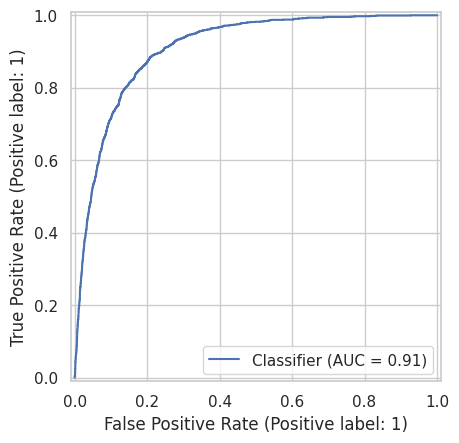

In [28]:
# ROC-AUC and ROC curve
y_proba = pipeline.predict_proba(X_test)[:,1]
print("ROC-AUC: {:.3f}".format(roc_auc_score(y_test, y_proba)))

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.show()


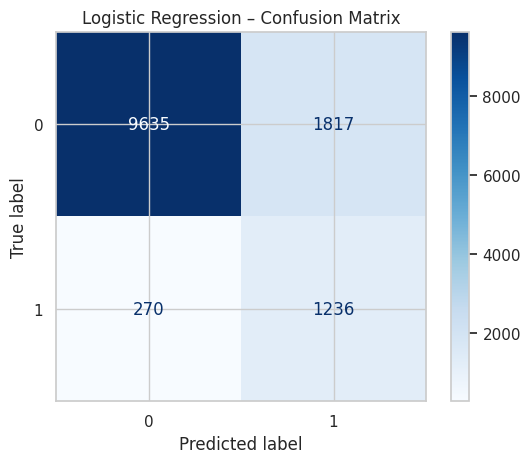

In [29]:
# Confusion-matrix graphic
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title("Logistic Regression – Confusion Matrix")
plt.show()


<ipython-input-30-cea21ba01954>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top, x='coef', y='feature', palette='Set2')


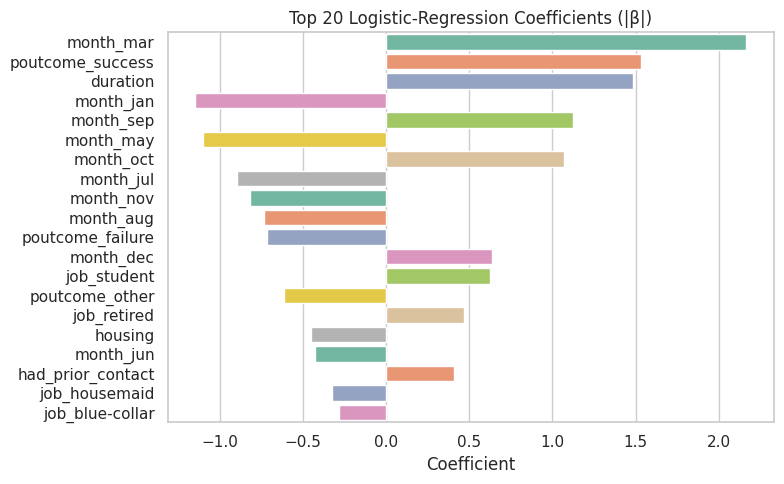

In [30]:
# Bar-plot of top logistic-regression coefficients

# 1) Recover feature names from the preprocessor
oh = pipeline.named_steps['prep'].named_transformers_['cat']
num_names = numeric_cols
cat_names = oh.get_feature_names_out(categorical_cols).tolist()
all_names = num_names + cat_names

# 2) Get and sort coefficients
coefs = pipeline.named_steps['clf'].coef_[0]
coef_df = pd.DataFrame({'feature': all_names, 'coef': coefs})
coef_df['abs'] = coef_df['coef'].abs()
top = coef_df.sort_values('abs', ascending=False).head(20)

# 3) Plot
plt.figure(figsize=(8,5))
sns.barplot(data=top, x='coef', y='feature', palette='Set2')
plt.title('Top 20 Logistic-Regression Coefficients (|β|)')
plt.xlabel('Coefficient')
plt.ylabel('')
plt.tight_layout()
plt.show()


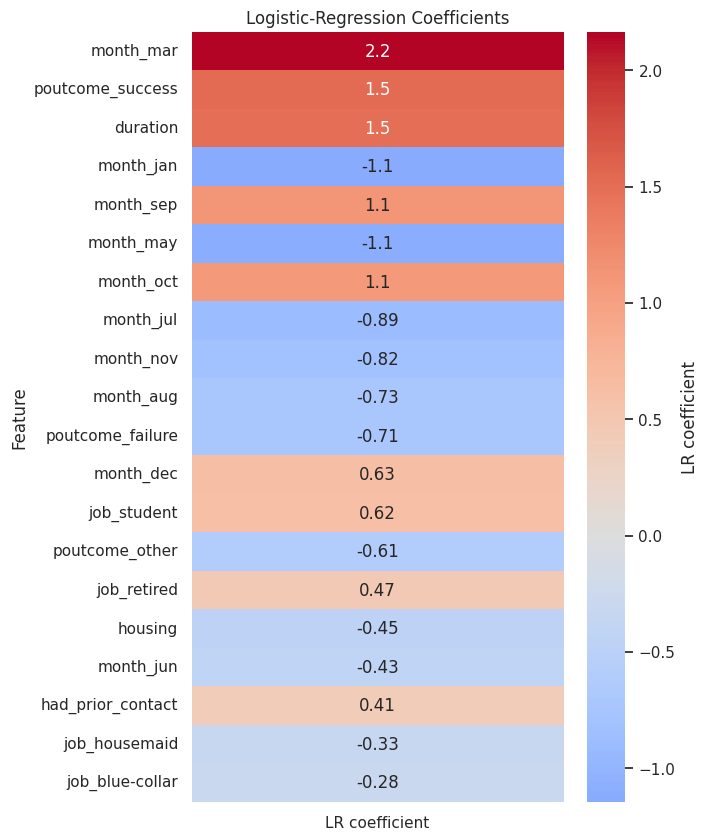

In [42]:
# Logistic-Regression Coefficients
# pull coefficients & names
coef_vec   = pipeline.named_steps['clf'].coef_[0]
coef_frame = pd.DataFrame({'Feature': all_names,
                           'LR coefficient': coef_vec}).set_index('Feature')

# select top positive & negative 10
top_coefs = coef_frame.reindex(
    coef_frame['LR coefficient'].abs().sort_values(ascending=False).head(20).index)

plt.figure(figsize=(6, 10))
sns.heatmap(top_coefs,
            annot=True,
            cmap='coolwarm',
            center=0,
            cbar_kws={'label':'LR coefficient'})
plt.title('Logistic-Regression Coefficients')
plt.show()

**Decision Tree**

In [31]:
#  Model Fit & Parameters

dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)

dt_pipe = Pipeline([('prep', preprocess),
                    ('clf',  dt)])

param_grid_dt = {
    'clf__max_depth': [None, 3, 5, 8, 12],
    'clf__min_samples_leaf': [1, 5, 20]
}

grid_dt = GridSearchCV(dt_pipe,
                       param_grid_dt,
                       scoring='roc_auc',
                       cv=5,
                       n_jobs=-1,
                       verbose=1)

grid_dt.fit(X_train, y_train)
print("Best DT params:", grid_dt.best_params_)


Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best DT params: {'clf__max_depth': 8, 'clf__min_samples_leaf': 20}


              precision    recall  f1-score   support

           0      0.977     0.780     0.868     11452
           1      0.341     0.862     0.488      1506

    accuracy                          0.790     12958
   macro avg      0.659     0.821     0.678     12958
weighted avg      0.903     0.790     0.824     12958

ROC-AUC: 0.8970408098656718


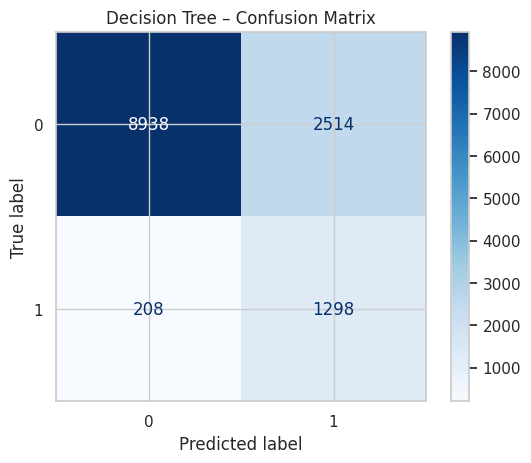

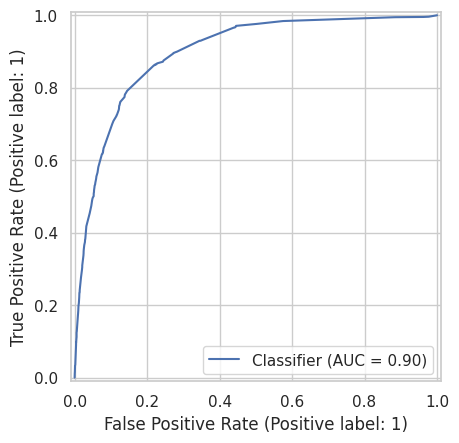

In [32]:
# Performance & Diagnostics
best_dt = grid_dt.best_estimator_

y_pred_dt  = best_dt.predict(X_test)
y_proba_dt = best_dt.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred_dt, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_dt))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_dt, cmap='Blues')
plt.title("Decision Tree – Confusion Matrix")
plt.show()

RocCurveDisplay.from_predictions(y_test, y_proba_dt)
plt.show()


<ipython-input-34-3289fb133512>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_imp, x='importance', y='feature', palette='crest')


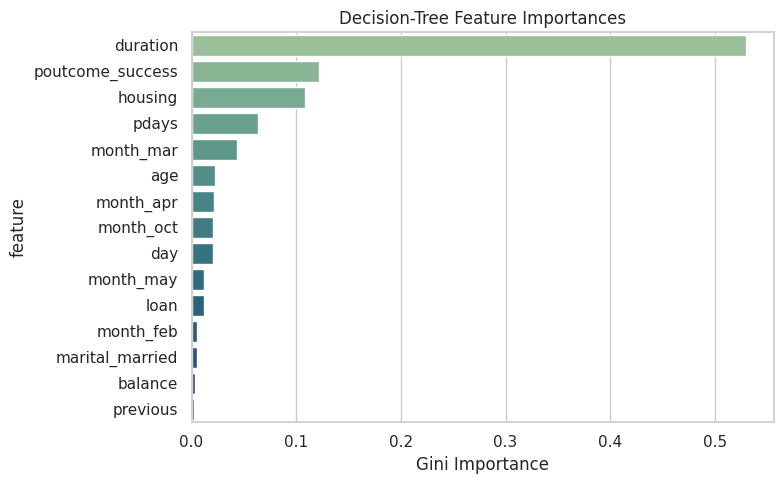

In [34]:
# Feature Importance
imp = best_dt.named_steps['clf'].feature_importances_
imp_df = pd.DataFrame({'feature': all_names, 'importance': imp})
top_imp = imp_df.sort_values('importance', ascending=False).head(15)

plt.figure(figsize=(8,5))
sns.barplot(data=top_imp, x='importance', y='feature', palette='crest')
plt.title('Decision-Tree Feature Importances')
plt.xlabel('Gini Importance')
plt.tight_layout()
plt.show()


**Random Forest**

In [35]:
# Model Fit & Parameters
rf = RandomForestClassifier(n_estimators=100,
                            class_weight='balanced',
                            random_state=42,
                            n_jobs=-1)

rf_pipe = Pipeline([('prep', preprocess),
                    ('clf',  rf)])

param_grid_rf = {
    'clf__n_estimators': [100, 300],
    'clf__max_depth': [None, 8, 15],
    'clf__min_samples_leaf': [1, 3, 10]
}

grid_rf = GridSearchCV(rf_pipe,
                       param_grid_rf,
                       scoring='roc_auc',
                       cv=3,
                       n_jobs=-1,
                       verbose=1)

grid_rf.fit(X_train, y_train)
print("Best RF params:", grid_rf.best_params_)



Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best RF params: {'clf__max_depth': None, 'clf__min_samples_leaf': 3, 'clf__n_estimators': 300}


              precision    recall  f1-score   support

           0      0.962     0.913     0.937     11452
           1      0.523     0.723     0.607      1506

    accuracy                          0.891     12958
   macro avg      0.742     0.818     0.772     12958
weighted avg      0.911     0.891     0.899     12958

ROC-AUC: 0.9266955927599418


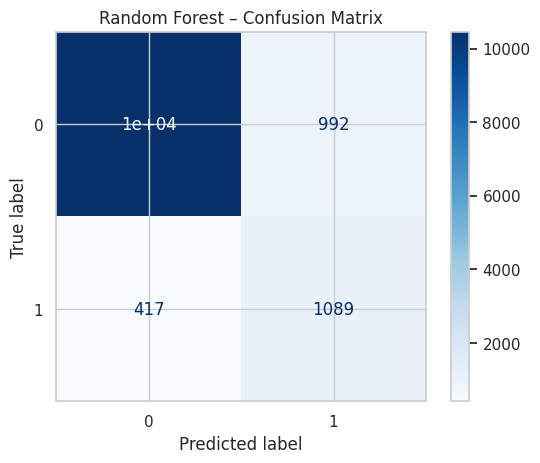

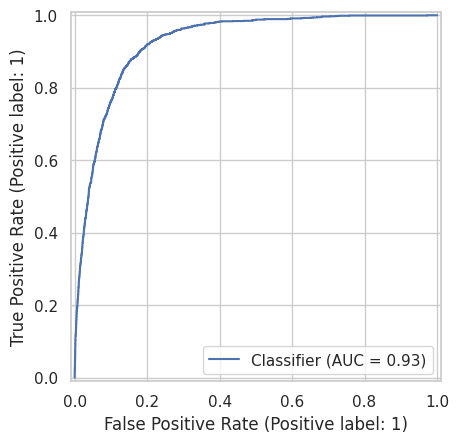

In [36]:
# Performance & Diagnostics
best_rf = grid_rf.best_estimator_

y_pred_rf  = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred_rf, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, cmap='Blues')
plt.title("Random Forest – Confusion Matrix")
plt.show()

RocCurveDisplay.from_predictions(y_test, y_proba_rf)
plt.show()


<ipython-input-37-bdd9184cd26f>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_rf, x='importance', y='feature', palette='flare')


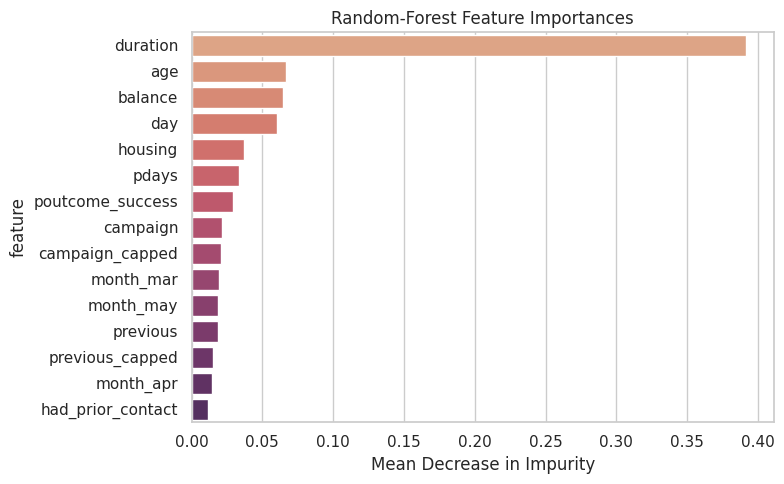

In [37]:
imp_rf = best_rf.named_steps['clf'].feature_importances_
imp_df_rf = pd.DataFrame({'feature': all_names, 'importance': imp_rf})
top_rf = imp_df_rf.sort_values('importance', ascending=False).head(15)

plt.figure(figsize=(8,5))
sns.barplot(data=top_rf, x='importance', y='feature', palette='flare')
plt.title('Random-Forest Feature Importances')
plt.xlabel('Mean Decrease in Impurity')
plt.tight_layout()
plt.show()


**KNN**

In [38]:
# Model Fit & Parameters
knn = KNeighborsClassifier()

knn_pipe = Pipeline([('prep', preprocess),
                     ('clf',  knn)])

param_grid_knn = {
    'clf__n_neighbors': [3, 5, 11, 21],
    'clf__weights': ['uniform', 'distance'],
    'clf__p': [1, 2]
}

grid_knn = GridSearchCV(knn_pipe,
                        param_grid_knn,
                        scoring='roc_auc',
                        cv=3,
                        n_jobs=-1,
                        verbose=1)

grid_knn.fit(X_train, y_train)
print("Best KNN params:", grid_knn.best_params_)


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best KNN params: {'clf__n_neighbors': 21, 'clf__p': 1, 'clf__weights': 'distance'}


              precision    recall  f1-score   support

           0      0.906     0.989     0.946     11452
           1      0.725     0.221     0.339      1506

    accuracy                          0.900     12958
   macro avg      0.816     0.605     0.642     12958
weighted avg      0.885     0.900     0.875     12958

ROC-AUC: 0.8817618685810954


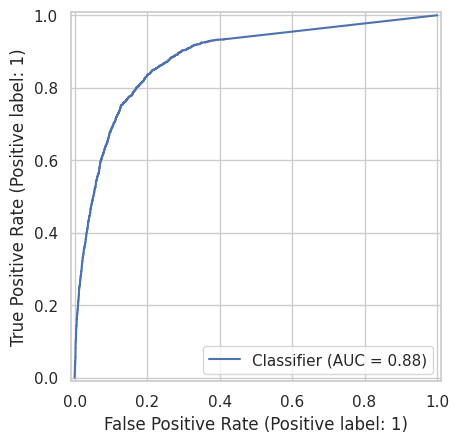

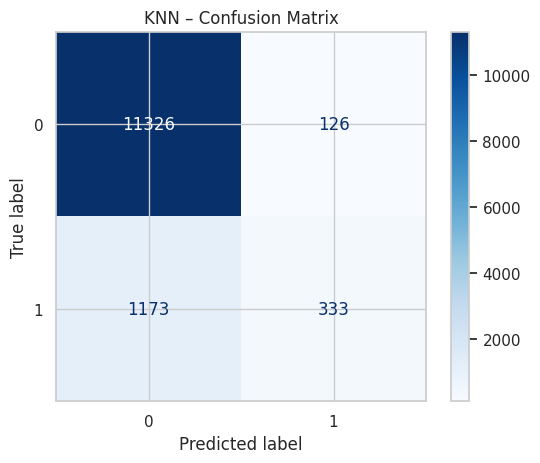

In [39]:
# Performance & Diagnostics
best_knn = grid_knn.best_estimator_

y_pred_knn  = best_knn.predict(X_test)
y_proba_knn = best_knn.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred_knn, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_knn))

RocCurveDisplay.from_predictions(y_test, y_proba_knn)
plt.show()

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_knn, cmap='Blues')
plt.title("KNN – Confusion Matrix")
plt.show()


**MLP**

In [40]:
# Model Fit & Parameters

mlp = MLPClassifier(
    max_iter=200,
    early_stopping=True,
    random_state=42
)

mlp_pipe = Pipeline([('prep', preprocess),
                     ('clf',  mlp)])

param_grid_mlp = {
    'clf__hidden_layer_sizes': [(100,), (50, 50), (100, 50)],
    'clf__alpha': [1e-4, 1e-3, 1e-2],
    'clf__learning_rate_init': [0.001, 0.01]
}

grid_mlp = GridSearchCV(mlp_pipe,
                        param_grid_mlp,
                        scoring='roc_auc',
                        cv=3,
                        n_jobs=-1,
                        verbose=1)

grid_mlp.fit(X_train, y_train)
print("Best MLP params:", grid_mlp.best_params_)


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best MLP params: {'clf__alpha': 0.01, 'clf__hidden_layer_sizes': (100, 50), 'clf__learning_rate_init': 0.001}


              precision    recall  f1-score   support

           0      0.948     0.944     0.946     11452
           1      0.588     0.604     0.596      1506

    accuracy                          0.905     12958
   macro avg      0.768     0.774     0.771     12958
weighted avg      0.906     0.905     0.905     12958

ROC-AUC: 0.9255699869053301


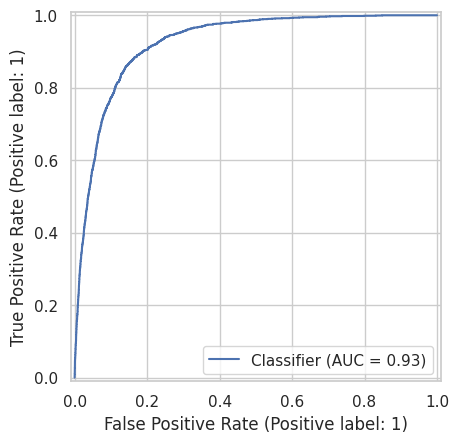

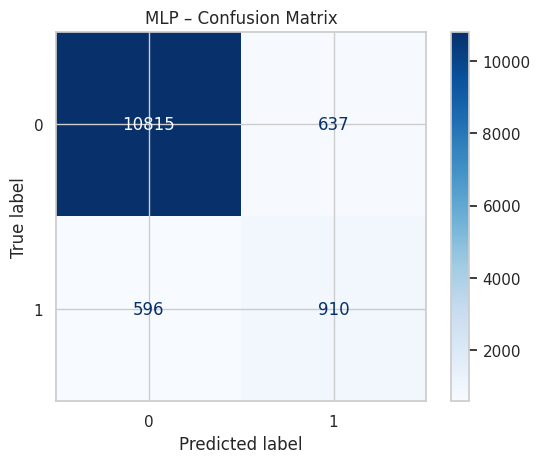

In [41]:
# Performance & Diagnostics
best_mlp = grid_mlp.best_estimator_

y_pred_mlp  = best_mlp.predict(X_test)
y_proba_mlp = best_mlp.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred_mlp, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_mlp))

RocCurveDisplay.from_predictions(y_test, y_proba_mlp)
plt.show()

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_mlp, cmap='Blues')
plt.title("MLP – Confusion Matrix")
plt.show()
